In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [170]:
df = pd.read_csv('Trace.csv', index_col=0)

In [171]:
time = pd.read_csv("Communication.csv", index_col=0)
time = time.fillna('')

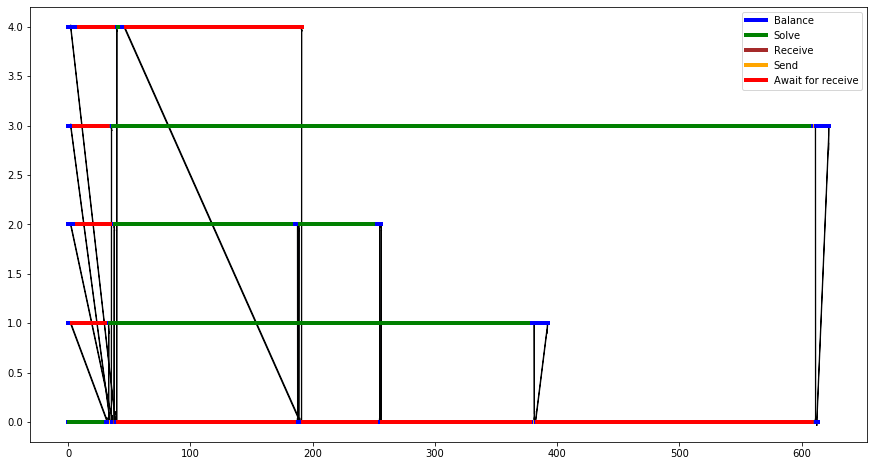

Acceleration is nearly:	1.865
Efficiency is nearly:	0.373


In [172]:
processes = len(df.columns) // 3
fig, ax = plt.subplots(figsize=(15,8))
# ax.arrow(55, 3, 14, -2, capstyle='projecting', head_width=.15, head_length=.15, length_includes_head=True, shape='full')

max_time = 0
status = {}
isLegendSet = False
Tseq = 0
for j in range(processes):
    x = list(df['timestamp' + str(j)].fillna(-1))[1:]
    y = list(df['state' + str(j)].fillna(-1))[1:]
    res = []
    for i, el in enumerate(x):
        if el == -1:
            continue
        el = list(map(float, el.split('-')))
        if el[1] > max_time:
            max_time = el[1]
        if y[i] == 'Await for receive':
            el.append('red')
        elif y[i] == 'Balance':
            el.append('blue')
        elif y[i] == 'Receive':
            el.append('brown')
        elif y[i] == 'Send':
            el.append('orange')
        elif y[i] == 'Solve':
            Tseq += el[1] - el[0]
            el.append('green')
        else:
            el.append('black')
        status[el[-1]] = False
        el.append(y[i])
        res.append(el)
    for el in res:
        if not status[el[2]] and not isLegendSet:
            status[el[2]] = True
            ax.plot(el[:-2], [j, j], color=el[2], linewidth=4.0, label=el[3])
        else:
            ax.plot(el[:-2], [j, j], color=el[2], linewidth=4.0)   
    isLegendSet = True
scale = processes / max_time
head_width = 2
length = head_width * scale
ax.legend()
for col in time.columns:
    sndr, rcvr = map(int, col[1:-1].split(', '))
    for interval in time[col]:
        if interval != '':
            start, end = map(float, interval.split(':'))
            y = abs(rcvr-sndr)
            x = end-start
            gip = math.sqrt(y ** 2 + x ** 2)
            sin = y / gip
            width = (0.5 / 2 - 0.025 / 2) * sin + 0.025 / 2
            cos = x / gip
            lenth = (0.5 - 0.025) * cos + 0.025
            
            ax.arrow(start, sndr, end-start, rcvr-sndr, length_includes_head=True, width=width, head_length=lenth)
plt.show()
     
acceleration = Tseq / max_time
print(f'Acceleration is nearly:\t{round(acceleration, 3)}')
efficiency = acceleration / processes
print(f'Efficiency is nearly:\t{round(efficiency, 3)}')



In [61]:
time = pd.read_csv("Communication.csv", index_col=0)
time = time.fillna('')
time.head()

,"(1, 0)","(0, 1)","(2, 0)","(0, 2)"
0,2.0:20.1,21.1:21.200000000000003,2.0:22.300000000000004,23.300000000000004:23.400000000000006
1,51.2:51.300000000000004,52.300000000000004:52.400000000000006,47.400000000000006:53.50000000000001,54.50000000000001:54.60000000000001
2,58.400000000000006:58.50000000000001,59.50000000000001:59.60000000000001,60.60000000000001:60.70000000000001,61.70000000000001:61.80000000000001
3,65.60000000000001:65.7,66.7:66.8,,


In [66]:
for col in time.columns:
    sndr, rcvr = col[1:-1].split(', ')
    print(f'{sndr} - {rcvr}')
#     print(time[col])

1 - 0
0 - 1
2 - 0
0 - 2


In [77]:
sndr, rcvr = map(float, "51.2:51.300000000000004".split(':'))

In [78]:
sndr

51.2

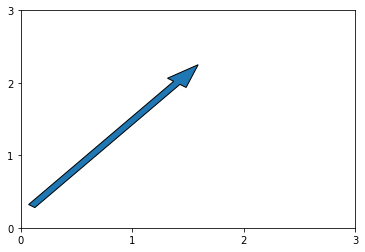

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.arrow(0.1, 0.3, 1.3, 1.7,
         width = 0.07)    #  ширина стрелки

#  Установим диапазон значений:
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])

plt.show()


In [129]:
import math
math.cos(math.pi)

-1.0

In [149]:
sta = {}
sta['r'] = 3

In [150]:
sta

{'r': 3}

In [151]:
status

{'blue': True, 'green': True, 'brown': True, 'orange': True, 'red': True}